In [1]:
import pandas as pd

In [2]:
from sklearn import preprocessing

In [3]:
account_list = pd.read_csv('./concept_drift_original/accounts.csv')

In [4]:
account_list

,acct_id,dsply_nm,type,acct_stat,acct_rptng_crncy,prior_sar_count,branch_id,open_dt,close_dt,initial_deposit,...,street_addr,city,state,country,zip,gender,birth_date,ssn,lon,lat
0,0,C_0,SAV,A,USD,False,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,89497.84,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
1,1,C_1,SAV,A,USD,False,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,64998.08,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
2,2,C_2,SAV,A,USD,True,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,64406.75,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
3,3,C_3,SAV,A,USD,False,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,70156.07,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
4,4,C_4,SAV,A,USD,False,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,87150.86,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,C_995,SAV,A,USD,False,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,55426.96,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
996,996,C_996,SAV,A,USD,True,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,93663.14,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
997,997,C_997,SAV,A,USD,False,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,69070.35,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN
998,998,C_998,SAV,A,USD,True,1,2020-01-01T00:00:00Z,4757-11-28T00:00:00Z,60356.55,...,NaN,NaN,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN


__Estrutura do `accounts.csv`__ (dados que iremos usar)

- __acct_id__: identificador único.
- __initial_deposit__: outro identificador único
- __tx_behaviour_id__: identificador do comportamento da conta

In [5]:
transactions = pd.read_csv('./concept_drift_original/transactions.csv')

In [6]:
transactions

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id
0,1,743,409,TRANSFER,727.06,2020-01-01T00:00:00Z,False,-1
1,2,883,751,TRANSFER,397.13,2020-01-01T00:00:00Z,False,-1
2,3,993,678,CASH_IN,933.56,2020-01-01T00:00:00Z,False,-1
3,4,993,192,TRANSFER,282.02,2020-01-01T00:00:00Z,False,-1
4,5,993,818,CASH_IN,867.38,2020-01-01T00:00:00Z,False,-1
...,...,...,...,...,...,...,...,...
55395,18454,81,260,DEBIT,5911.59,2020-12-31T00:00:00Z,False,-1
55396,18455,946,943,DEBIT,5876.81,2020-12-31T00:00:00Z,False,-1
55397,18456,439,278,CASH_IN,6753.49,2020-12-31T00:00:00Z,False,-1
55398,18457,808,642,TRANSFER,2262.44,2020-12-31T00:00:00Z,False,-1


### Seleção de Transações

In [7]:
transactions[transactions.is_sar]

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id
14,15,863,730,TRANSFER,115.26,2020-01-01T00:00:00Z,True,12
17,18,774,217,TRANSFER,199.22,2020-01-01T00:00:00Z,True,16
18,19,774,883,DEPOSIT,199.22,2020-01-01T00:00:00Z,True,16
31,32,634,400,DEPOSIT,104.80,2020-01-01T00:00:00Z,True,4
74,75,361,374,TRANSFER,147.03,2020-01-01T00:00:00Z,True,8
...,...,...,...,...,...,...,...,...
53549,16608,571,443,DEPOSIT,128.09,2020-12-19T00:00:00Z,True,47
54253,17312,768,208,CASH_IN,76.64,2020-12-24T00:00:00Z,True,36
54254,17313,537,770,TRANSFER,68.98,2020-12-24T00:00:00Z,True,36
54768,17827,443,516,CASH_IN,115.28,2020-12-27T00:00:00Z,True,47


In [8]:

sample_falses = transactions[transactions['is_sar'] == False].sample(20349)

In [9]:
len(sample_falses.tran_timestamp.unique())

366

In [10]:
transactions = transactions[(transactions.index.isin(sample_falses.index)) | (transactions.is_sar)]

In [11]:
transactions2 = transactions.copy()
transactions2['ilicit'] = pd.get_dummies(transactions.is_sar)[True]
transactions2['licit'] = pd.get_dummies(transactions.is_sar)[False]

In [12]:
transactions2

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id,ilicit,licit
1,2,883,751,TRANSFER,397.13,2020-01-01T00:00:00Z,False,-1,0,1
7,8,673,742,TRANSFER,211.31,2020-01-01T00:00:00Z,False,-1,0,1
8,9,46,965,CASH_OUT,538.13,2020-01-01T00:00:00Z,False,-1,0,1
9,10,111,207,CASH_IN,557.29,2020-01-01T00:00:00Z,False,-1,0,1
11,12,944,605,CASH_IN,447.48,2020-01-01T00:00:00Z,False,-1,0,1
...,...,...,...,...,...,...,...,...,...,...
55380,18439,580,437,CASH_OUT,5409.25,2020-12-31T00:00:00Z,False,-1,0,1
55384,18443,526,460,PAYMENT,9516.18,2020-12-31T00:00:00Z,False,-1,0,1
55386,18445,977,315,CASH_OUT,2786.81,2020-12-31T00:00:00Z,False,-1,0,1
55388,18447,198,669,DEPOSIT,8218.16,2020-12-31T00:00:00Z,False,-1,0,1


In [13]:
transactions2 = transactions2[['tran_timestamp', 'licit', 'ilicit']].groupby('tran_timestamp').sum().reset_index()

In [14]:
transactions2['tran_timestamp'] = pd.to_datetime(transactions2['tran_timestamp'])

In [15]:
transactions2['licit'] = transactions2['licit'].cumsum()
transactions2['ilicit'] = transactions2['ilicit'].cumsum()

In [16]:
transactions2.index = transactions2.tran_timestamp

In [17]:
transactions2

,tran_timestamp,licit,ilicit
tran_timestamp,,,
2020-01-01 00:00:00+00:00,2020-01-01 00:00:00+00:00,53,15
2020-01-02 00:00:00+00:00,2020-01-02 00:00:00+00:00,111,23
2020-01-03 00:00:00+00:00,2020-01-03 00:00:00+00:00,163,28
2020-01-04 00:00:00+00:00,2020-01-04 00:00:00+00:00,217,35
2020-01-05 00:00:00+00:00,2020-01-05 00:00:00+00:00,271,40
...,...,...,...
2020-12-27 00:00:00+00:00,2020-12-27 00:00:00+00:00,20110,1070
2020-12-28 00:00:00+00:00,2020-12-28 00:00:00+00:00,20169,1070
2020-12-29 00:00:00+00:00,2020-12-29 00:00:00+00:00,20241,1070


In [18]:
transactions2.drop(columns=['tran_timestamp'], inplace=True)

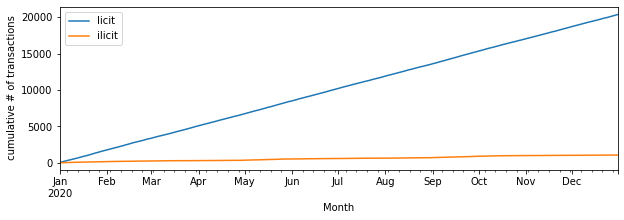

In [19]:
plot = transactions2.plot(figsize=(10,3), xlabel='Month', ylabel=' cumulative # of transactions')

In [20]:
fig = plot.get_figure()
fig.savefig("tr_sc1_cum_sum.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [21]:
transactions2['licit2'] = transactions2['licit'] / (transactions2['licit'] + transactions2['ilicit'])
transactions2['ilicit2'] = transactions2['ilicit'] / (transactions2['licit'] + transactions2['ilicit'])

In [22]:
transactions2

,licit,ilicit,licit2,ilicit2
tran_timestamp,,,,
2020-01-01 00:00:00+00:00,53,15,0.779412,0.220588
2020-01-02 00:00:00+00:00,111,23,0.828358,0.171642
2020-01-03 00:00:00+00:00,163,28,0.853403,0.146597
2020-01-04 00:00:00+00:00,217,35,0.861111,0.138889
2020-01-05 00:00:00+00:00,271,40,0.871383,0.128617
...,...,...,...,...
2020-12-27 00:00:00+00:00,20110,1070,0.949481,0.050519
2020-12-28 00:00:00+00:00,20169,1070,0.949621,0.050379
2020-12-29 00:00:00+00:00,20241,1070,0.949791,0.050209


In [23]:
transactions2['licit'] = transactions2['licit2'] * 100
transactions2['ilicit'] = transactions2['ilicit2'] * 100


In [24]:
transactions2 = transactions2.drop(columns=['licit2', 'ilicit2'])

In [25]:
transactions2

,licit,ilicit
tran_timestamp,,
2020-01-01 00:00:00+00:00,77.941176,22.058824
2020-01-02 00:00:00+00:00,82.835821,17.164179
2020-01-03 00:00:00+00:00,85.340314,14.659686
2020-01-04 00:00:00+00:00,86.111111,13.888889
2020-01-05 00:00:00+00:00,87.138264,12.861736
...,...,...
2020-12-27 00:00:00+00:00,94.948064,5.051936
2020-12-28 00:00:00+00:00,94.962098,5.037902
2020-12-29 00:00:00+00:00,94.979119,5.020881


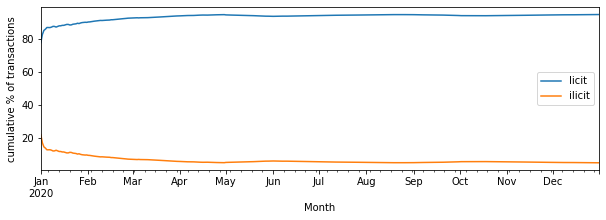

In [26]:
plot = transactions2.plot(figsize=(10,3), xlabel='Month', ylabel='cumulative % of transactions')

In [27]:
fig = plot.get_figure()
fig.savefig("tr_sc1_cum_per.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Fim da seleção de transações

In [28]:
tx_types = pd.get_dummies(transactions.tx_type)

In [29]:
for col in tx_types.columns:
    transactions.insert(7, col, tx_types[col].values, True)

In [30]:
transactions

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,TRANSFER,PAYMENT,DEPOSIT,DEBIT,CASH_OUT,CASH_IN,alert_id
1,2,883,751,TRANSFER,397.13,2020-01-01T00:00:00Z,False,1,0,0,0,0,0,-1
7,8,673,742,TRANSFER,211.31,2020-01-01T00:00:00Z,False,1,0,0,0,0,0,-1
8,9,46,965,CASH_OUT,538.13,2020-01-01T00:00:00Z,False,0,0,0,0,1,0,-1
9,10,111,207,CASH_IN,557.29,2020-01-01T00:00:00Z,False,0,0,0,0,0,1,-1
11,12,944,605,CASH_IN,447.48,2020-01-01T00:00:00Z,False,0,0,0,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55380,18439,580,437,CASH_OUT,5409.25,2020-12-31T00:00:00Z,False,0,0,0,0,1,0,-1
55384,18443,526,460,PAYMENT,9516.18,2020-12-31T00:00:00Z,False,0,1,0,0,0,0,-1
55386,18445,977,315,CASH_OUT,2786.81,2020-12-31T00:00:00Z,False,0,0,0,0,1,0,-1
55388,18447,198,669,DEPOSIT,8218.16,2020-12-31T00:00:00Z,False,0,0,1,0,0,0,-1


In [31]:
transactions['tran_timestamp'] = (pd.to_datetime(transactions['tran_timestamp']) - pd.Timestamp('1970-01-01 00:00:00+00:00'))//pd.Timedelta('1s')

/tmp/ipykernel_16566/930615775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['tran_timestamp'] = (pd.to_datetime(transactions['tran_timestamp']) - pd.Timestamp('1970-01-01 00:00:00+00:00'))//pd.Timedelta('1s')


In [32]:
transactions['tran_timestamp'] 

1        1577836800
7        1577836800
8        1577836800
9        1577836800
11       1577836800
            ...    
55380    1609372800
55384    1609372800
55386    1609372800
55388    1609372800
55394    1609372800
Name: tran_timestamp, Length: 21420, dtype: int64

In [33]:
transactions.drop(columns=['tx_type'], inplace=True)

/tmp/ipykernel_16566/4103867722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions.drop(columns=['tx_type'], inplace=True)


In [34]:
transactions.drop(columns=['tran_id'], inplace=True)

/tmp/ipykernel_16566/1350592409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions.drop(columns=['tran_id'], inplace=True)


In [35]:
transactions.drop(columns=['alert_id'], inplace=True)

/tmp/ipykernel_16566/3632735273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions.drop(columns=['alert_id'], inplace=True)


In [36]:
transactions

,orig_acct,bene_acct,base_amt,tran_timestamp,is_sar,TRANSFER,PAYMENT,DEPOSIT,DEBIT,CASH_OUT,CASH_IN
1,883,751,397.13,1577836800,False,1,0,0,0,0,0
7,673,742,211.31,1577836800,False,1,0,0,0,0,0
8,46,965,538.13,1577836800,False,0,0,0,0,1,0
9,111,207,557.29,1577836800,False,0,0,0,0,0,1
11,944,605,447.48,1577836800,False,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
55380,580,437,5409.25,1609372800,False,0,0,0,0,1,0
55384,526,460,9516.18,1609372800,False,0,1,0,0,0,0
55386,977,315,2786.81,1609372800,False,0,0,0,0,1,0
55388,198,669,8218.16,1609372800,False,0,0,1,0,0,0


In [37]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

def scale_columns(df, cols_to_scale):
    for col in cols_to_scale: 
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [38]:
transactions = transactions.reset_index(drop=True)

In [39]:
transactions

,orig_acct,bene_acct,base_amt,tran_timestamp,is_sar,TRANSFER,PAYMENT,DEPOSIT,DEBIT,CASH_OUT,CASH_IN
0,883,751,397.13,1577836800,False,1,0,0,0,0,0
1,673,742,211.31,1577836800,False,1,0,0,0,0,0
2,46,965,538.13,1577836800,False,0,0,0,0,1,0
3,111,207,557.29,1577836800,False,0,0,0,0,0,1
4,944,605,447.48,1577836800,False,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
21415,580,437,5409.25,1609372800,False,0,0,0,0,1,0
21416,526,460,9516.18,1609372800,False,0,1,0,0,0,0
21417,977,315,2786.81,1609372800,False,0,0,0,0,1,0
21418,198,669,8218.16,1609372800,False,0,0,1,0,0,0


In [40]:
transactions = scale_columns(transactions.copy(), ['tran_timestamp'])

In [41]:
transactions = scale_columns(transactions.copy(), ['base_amt', 'tran_timestamp', 'TRANSFER', 'PAYMENT', 'DEPOSIT', 'DEBIT', 'CASH_OUT', 'CASH_IN'])

In [42]:
account_list = account_list[['acct_id', 'initial_deposit', 'tx_behavior_id']]

In [43]:
account_list

,acct_id,initial_deposit,tx_behavior_id
0,0,89497.84,1
1,1,64998.08,1
2,2,64406.75,1
3,3,70156.07,1
4,4,87150.86,1
...,...,...,...
995,995,55426.96,5
996,996,93663.14,5
997,997,69070.35,5
998,998,60356.55,5


In [44]:
behaviors = pd.get_dummies(account_list.tx_behavior_id)

In [45]:
for col in behaviors.columns:
    account_list.insert(3, col, behaviors[col].values, True)

In [46]:
account_list = account_list.drop(columns=['tx_behavior_id'])

In [47]:
account_list

,acct_id,initial_deposit,5,4,3,2,1
0,0,89497.84,0,0,0,0,1
1,1,64998.08,0,0,0,0,1
2,2,64406.75,0,0,0,0,1
3,3,70156.07,0,0,0,0,1
4,4,87150.86,0,0,0,0,1
...,...,...,...,...,...,...,...
995,995,55426.96,1,0,0,0,0
996,996,93663.14,1,0,0,0,0
997,997,69070.35,1,0,0,0,0
998,998,60356.55,1,0,0,0,0


In [48]:
account_list = scale_columns(account_list, ['initial_deposit', 5, 4, 3, 2, 1])

In [49]:
account_list

,acct_id,initial_deposit,5,4,3,2,1
0,0,0.789788,0.0,0.0,0.0,0.0,1.0
1,1,0.299395,0.0,0.0,0.0,0.0,1.0
2,2,0.287558,0.0,0.0,0.0,0.0,1.0
3,3,0.402638,0.0,0.0,0.0,0.0,1.0
4,4,0.742810,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
995,995,0.107817,1.0,0.0,0.0,0.0,0.0
996,996,0.873162,1.0,0.0,0.0,0.0,0.0
997,997,0.380906,1.0,0.0,0.0,0.0,0.0
998,998,0.206489,1.0,0.0,0.0,0.0,0.0


In [50]:
transactions.tran_timestamp

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21415    1.0
21416    1.0
21417    1.0
21418    1.0
21419    1.0
Name: tran_timestamp, Length: 21420, dtype: float64

In [51]:
sorted(list(set(transactions.tran_timestamp.values)))

[0.0,
 0.0027397260274000246,
 0.005479452054792944,
 0.008219178082192968,
 0.010958904109592993,
 0.013698630136985912,
 0.016438356164385937,
 0.019178082191778856,
 0.02191780821917888,
 0.024657534246578905,
 0.027397260273971824,
 0.03013698630137185,
 0.03287671232877187,
 0.03561643835616479,
 0.03835616438356482,
 0.041095890410957736,
 0.04383561643835776,
 0.046575342465757785,
 0.049315068493150704,
 0.05205479452055073,
 0.05479452054794365,
 0.05753424657534367,
 0.0602739726027437,
 0.06301369863013662,
 0.06575342465753664,
 0.06849315068492956,
 0.07123287671232958,
 0.07397260273972961,
 0.07671232876712253,
 0.07945205479452255,
 0.08219178082192258,
 0.0849315068493155,
 0.08767123287671552,
 0.09041095890410844,
 0.09315068493150847,
 0.09589041095890849,
 0.09863013698630141,
 0.10136986301370143,
 0.10410958904109435,
 0.10684931506849438,
 0.1095890410958944,
 0.11232876712328732,
 0.11506849315068735,
 0.11780821917808026,
 0.12054794520548029,
 0.1232876712328

In [52]:
len(sorted(list(set(transactions.tran_timestamp.values))))

366

In [53]:
#################

In [54]:
import torch
from torch_geometric.data import Data


def get_converted_index(old, acc_list):
    return acc_list.index(old)


graphs = []

tran_timestamps = sorted(list(set(transactions.tran_timestamp.values)))
for i, timestamp in enumerate(tran_timestamps):
    timestamp_transacs = transactions[transactions.tran_timestamp == timestamp]
    t_sender_accs = timestamp_transacs.orig_acct.values.tolist()
    t_receiver_accs = timestamp_transacs.bene_acct.values.tolist()
    timestamp_accs = list(set(t_sender_accs + t_receiver_accs))
    timestamp_accs.sort()
    t_accs_features = account_list.loc[timestamp_accs].reset_index()\
        .reset_index()[['initial_deposit', 5, 4, 3, 2, 1]]
    timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
        .apply(lambda line: get_converted_index(line, timestamp_accs))
    timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
        .apply(lambda line: get_converted_index(line, timestamp_accs))
    edge_index = torch.tensor(timestamp_transacs[['orig_acct', 'bene_acct']].values.T)
    edge_attr = torch.tensor(timestamp_transacs[['base_amt', 'tran_timestamp', 'TRANSFER', 'PAYMENT', 'DEPOSIT', 'DEBIT', 'CASH_OUT', 'CASH_IN']].values.T)
    y = torch.tensor(timestamp_transacs['is_sar'].astype('int64').values)
    x = torch.tensor(t_accs_features.values.T)
    edge_to_edge_adj_matr = torch.eye(edge_attr.T.shape[0])
    edge_to_node_adj_matr = torch.zeros([edge_attr.T.shape[0], x.T.shape[0]])                                                         
    node_to_edge_adj_matr = torch.zeros([x.T.shape[0], edge_attr.T.shape[0]])
    node_to_node_adj_matr = torch.eye(x.T.shape[0])
    for n, ei in enumerate(edge_index.T):
        node_to_node_adj_matr[ei[0]][ei[1]] = 1.0
        node_to_edge_adj_matr[ei[0]][n] = 1.0
        node_to_edge_adj_matr[ei[1]][n] = 1.0
        edge_to_node_adj_matr[n][ei[1]] = 1.0
        edge_to_node_adj_matr[n][ei[0]] = 1.0
    
    for n, ei in enumerate(edge_index.T):
        for n2, e2 in enumerate(edge_to_node_adj_matr[:, ei[0]]):
            if e2 == 1.0:
                edge_to_edge_adj_matr[n2][n] = 1.0
    data = Data(
        x=x,
        y=y,
        edge_attr=edge_attr,
        edge_index=edge_index,
        node_to_node_adj_matr=node_to_node_adj_matr,
        node_to_edge_adj_matr=node_to_edge_adj_matr,
        edge_to_node_adj_matr=edge_to_node_adj_matr,
        edge_to_edge_adj_matr=edge_to_edge_adj_matr
    )
    graphs.append(data)

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.bene_acct = timestamp_transacs.bene_acct\
/tmp/ipykernel_16566/3881900895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamp_transacs.orig_acct = timestamp_transacs.orig_acct\
/tmp/ipykernel_16566/3881900895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [55]:
graphs[120].y

tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [56]:
import os

NAME_DIR = 'concept_drift_201/'

if not os.path.exists(NAME_DIR):
    os.mkdir(NAME_DIR)

for i, g in enumerate(graphs):
    name_out = NAME_DIR + str(i) + '.pt'
    torch.save(g, name_out)